<a href="https://colab.research.google.com/github/mirpouya/Northwind-DWH/blob/main/Analytics_2_(SQLlite)_Northwind_Traders_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Connect to SQL database
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
# Get Table Names and Table Information
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

2023-12-06 17:57:23,147 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2023-12-06 17:57:23,168 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name


2023-12-06 17:57:23,174 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2023-12-06 17:57:23,192 INFO sqlalchemy.engine.Engine ROLLBACK


INFO:sqlalchemy.engine.Engine:ROLLBACK


[]

Note: Table names listed in the ERD are all plural (e.g. 'Employees'), while in reality, the table names are actually singular (e.g. 'Employee')

In [ ]:
# Get all the information from the OrderDetails table.
# Will use Quantity column to examine of discount has an effect on amount of quantity ordered by customers
order_details_df = pd.read_sql_query('''SELECT * FROM OrderDetail''', engine)
order_details_df.head()

2019-03-11 16:45:37,203 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-03-11 16:45:37,205 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [ ]:
# Check for nulls
order_details_df.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [ ]:
order_details_df.shape

(2155, 6)

In [ ]:
order_details_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


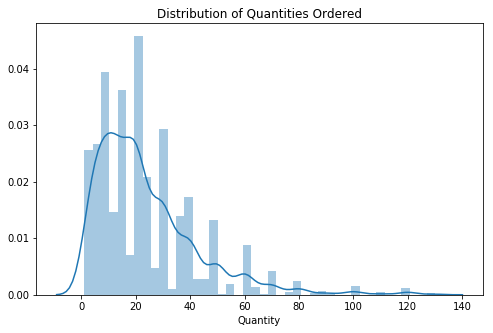

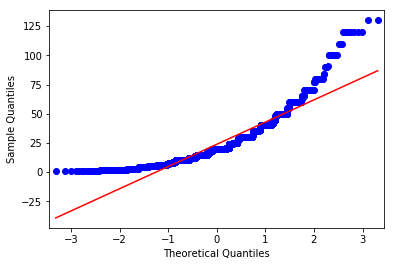

In [ ]:
# Visualize data for normality
plt.figure(figsize=(8,5))
sns.distplot(order_details_df.Quantity)
plt.title('Distribution of Quantities Ordered')
sm.qqplot(order_details_df.Quantity, line='s')
plt.show()

Looking at the histogram and the QQ Plot of the data, we see that it isn't normally distributed.
<br>
However, this shouldn't be an issue since our population size is very large, over 2,000, and the samples we pull from it will be large enough where a t-test is still valid due to it assuming that the means of the samples are from a normal distribution through the CLT, rather than assuming the population is from a normal distribution.

## Create control and experiement group

The control group will be the data of orders without a discount.
<br>
The experiment group will be the data of orders with a discount.

In [ ]:
no_discount = order_details_df[order_details_df['Discount'] == 0.0]['Quantity']
discount = order_details_df[order_details_df['Discount'] != 0.0]['Quantity']

In [ ]:
print(len(no_discount), len(discount))

1317 838


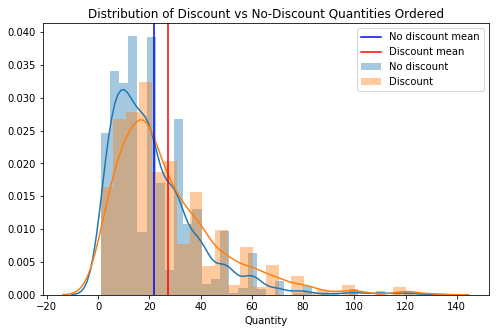

In [ ]:
# Visualize Groups
plt.figure(figsize=(8,5))
sns.distplot(no_discount, label='No discount')
sns.distplot(discount, label='Discount')
plt.axvline(np.mean(no_discount), color='blue', label='No discount mean')
plt.axvline(np.mean(discount), color='red', label='Discount mean')
plt.title('Distribution of Discount vs No-Discount Quantities Ordered')
plt.legend()
plt.show()

In [ ]:
print('Mean for no discount:', np.mean(no_discount))
print('Mean for discount:', np.mean(discount))
print('Mean difference:', np.mean(discount) - np.mean(no_discount))

Mean for no discount: 21.715261958997722
Mean for discount: 27.10978520286396
Mean difference: 5.394523243866239


## Hypothesis
Null Hypothesis: The average amount ordered with no discount(control) is at least the same as the average amount ordered with a discount(experiment).
<br>

$H_0: \mu_c $\>=$ \mu_e$
<br>

Alternative Hypothesis: The average amount ordered with a discount(experiment) is greater than the average amount ordered with no discount(control).
<br>

$H_a: \mu_c < \mu_e$
<br>

Basically we want to see if customers order a statistically significant amount more when there is a discount on products or does the discount not have any statistical significance.

## Select Alpha

We will be using an Alpha $\alpha$ of 0.05, this is a common alpha in order to reduce both type I and type II to an acceptable level.  

## Two Sample T-Test (one tail)
For this hypothesis test, since we are comparing two sample means from continuous data against each other to test for significance, we will use a two sample t-test.

In [ ]:
# Check to see if variance is the same between the samples
print('Variance No discount:', np.var(no_discount))
print('Variance Discount:', np.var(discount))

Variance No discount: 306.2795924332757
Variance Discount: 430.93782787748984


Since the variance for our samples are different we will use a Welche's two sample t-test

In [ ]:
t_stat, p_val = stats.ttest_ind(no_discount, discount, equal_var=False)
print('P-Value:', p_val/2)

P-Value: 2.828207145152165e-10


## Accept or Reject
This p-value is divided by 2 because it is a one tail t-test. We get a p-value < 0.05 which means that we can reject our Null Hypothesis and accept the Alternative Hypothesis that there is a statistical significance between the samples.  From our alpha, we can be 95% sure that there is a statistical significance that shows the average amount of items sold with a discount is greater than the average amount sold of items without a discount without this being due to random chance.

## Effect Size
We can use Cohen's $d$ in order to measure the effect size or represent the differentiation between our two sample groups.  

In [ ]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)

    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)

    return d

In [ ]:
d = Cohen_d(discount, no_discount)
print('d = {}'.format(d))

d = 0.2862724481729282


An effect of 0.28 is considered a small effect.  Although it is small, it still means that there is a an effect happening but it is not so obvious to see without investigating like we have with our hypothesis testing.

## ANOVA Test
Since we have rejected the Null Hypothesis, we will run ANOVA test to see if there is any significance among the different discounts.

In [ ]:
# Wrap Discount in C for categorical
formula  = 'Quantity ~ C(Discount)'
lm = ols(formula, data=order_details_df).fit()
table = sm.stats.anova_lm(lm, type=2)
print(table)

                 df         sum_sq     mean_sq         F        PR(>F)
C(Discount)    10.0   21258.403604  2125.84036  6.011811  4.704231e-09
Residual     2144.0  758141.232591   353.61065       NaN           NaN


The model shows from our p-value: PR(>F) 4.7e-09 that it is less than our alpha of 0.05 meaning there is a statistical significance between the discounts, but we cannot tell from this test which discount levels exactly.

## Tukey Test
Now that we have shown that discounts have a statistically significant effect on the number of products customers order, we want to know at what level of discounts specifically this effect takes place. For this we will use a Tukey test since this will tell us specifically which discounts have significance.

In [ ]:
# Different discounts given
order_details_df.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [ ]:
# Group our orders by discount
# Note discounts below 5% and at 6% rarely have happened
order_details_df.Quantity.groupby(order_details_df.Discount).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [ ]:
mc = MultiComparison(order_details_df.Quantity, order_details_df.Discount)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

## Results
Here the Tukey test shows that at discount levels of 5%, 15%, 20%, and 25% there is a significant difference in the quantity ordered compared to when there is no discount. With 95% confidence this significance isn't due to random chance.  This information is valuable for Northwind because this means that they don't need to offer discounts of the other ranges since it has no statistically significant effect on the amount customers will buy.  Essentially meaning that with the discounts with no significance, they are offering the products cheaper when it has no effect and customers would most likely purchase the same amount with or without the insignificant discount.



**_Is there a statistically significant difference between the amount of revenue brought in on average from employees in the US versus in the UK? What about among different employees?_**



In [ ]:
# Get data on employees and their orders
employee_sales_df = pd.read_sql_query('''SELECT od.OrderId, o.EmployeeId, e.LastName, e.FirstName,
                                            e.TitleOfCourtesy, e.Title, e.Country,
                                            SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) Revenue
                                            FROM Employee e
                                            JOIN [Order] o ON e.Id = o.EmployeeId
                                            JOIN OrderDetail od ON o.Id = od.OrderId
                                            GROUP BY od.OrderId''', engine)
employee_sales_df.head()

2019-03-11 16:46:38,554 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, o.EmployeeId, e.LastName, e.FirstName,
                                            e.TitleOfCourtesy, e.Title, e.Country,
                                            SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) Revenue
                                            FROM Employee e 
                                            JOIN [Order] o ON e.Id = o.EmployeeId
                                            JOIN OrderDetail od ON o.Id = od.OrderId
                                            GROUP BY od.OrderId
2019-03-11 16:46:38,555 INFO sqlalchemy.engine.base.Engine ()


,OrderId,EmployeeId,LastName,FirstName,TitleOfCourtesy,Title,Country,Revenue
0,10248,5,Buchanan,Steven,Mr.,Sales Manager,UK,440.00
1,10249,6,Suyama,Michael,Mr.,Sales Representative,UK,1863.40
2,10250,4,Peacock,Margaret,Mrs.,Sales Representative,USA,1552.60
3,10251,3,Leverling,Janet,Ms.,Sales Representative,USA,654.06
4,10252,4,Peacock,Margaret,Mrs.,Sales Representative,USA,3597.90


In [ ]:
employee_sales_df.shape

(830, 8)

In [ ]:
employee_sales_df.isna().sum()

OrderId            0
EmployeeId         0
LastName           0
FirstName          0
TitleOfCourtesy    0
Title              0
Country            0
Revenue            0
dtype: int64

In [ ]:
employee_sales_df.EmployeeId.unique()

array([5, 6, 4, 3, 9, 1, 8, 2, 7])

In [ ]:
employee_sales_df.Revenue.describe()

count      830.000000
mean      1525.051855
std       1845.178595
min         12.500000
25%        456.688750
50%        943.250000
75%       1882.200000
max      16387.500000
Name: Revenue, dtype: float64

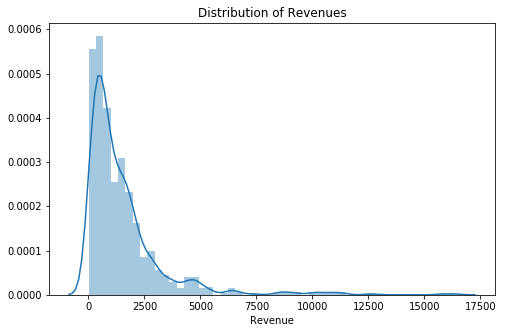

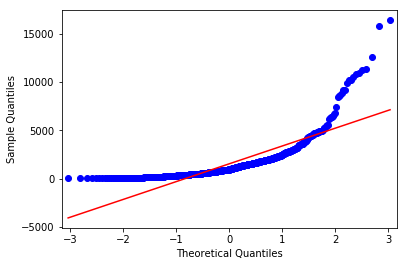

In [ ]:
# Visualize data for normality
plt.figure(figsize=(8,5))
sns.distplot(employee_sales_df.Revenue)
plt.title('Distribution of Revenues')
sm.qqplot(employee_sales_df.Revenue, line='s')
plt.show()

## Create Two Sample Groups

In [ ]:
usa = employee_sales_df[employee_sales_df['Country'] == 'USA']['Revenue']
uk = employee_sales_df[employee_sales_df['Country'] == 'UK']['Revenue']

In [ ]:
# Note more orders filled in the US
usa.shape, uk.shape

((606,), (224,))

In [ ]:
employee_sales_df.Revenue.groupby(employee_sales_df.Country).describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
UK,224.0,1538.311221,1892.265365,12.5,454.06625,868.6500,1896.0875,12615.05
USA,606.0,1520.150703,1829.031323,18.4,456.75000,1013.8725,1847.6600,16387.50


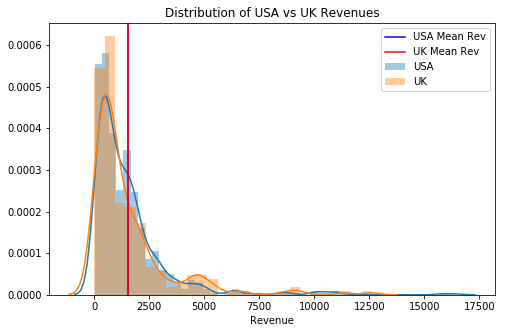

In [ ]:
# Visualize Groups
plt.figure(figsize=(8,5))
sns.distplot(usa, label='USA')
sns.distplot(uk, label='UK')
plt.axvline(np.mean(usa), color='blue', label='USA Mean Rev')
plt.axvline(np.mean(uk), color='red', label='UK Mean Rev')
plt.title('Distribution of USA vs UK Revenues')
plt.legend()
plt.show()

In [ ]:
print('Mean for USA:', np.mean(usa))
print('Mean for UK:', np.mean(uk))
print('Difference in Means:', np.mean(uk) - np.mean(usa))

Mean for USA: 1520.150702970297
Mean for UK: 1538.311220982143
Difference in Means: 18.160518011845852


Although there are almost three times more orders, and therefore a higher total revenue in the USA, the UK has a higher mean revenue.

In [ ]:
original_diff = np.mean(uk) - np.mean(usa)

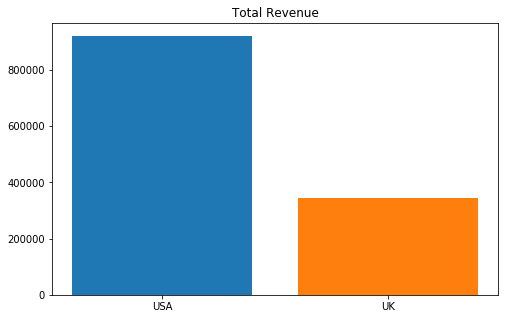

In [ ]:
plt.figure(figsize=(8,5))
plt.bar('USA', usa.sum())
plt.bar('UK', uk.sum())
plt.title('Total Revenue')
plt.show()

## Hypothesis
Null Hypothesis: The average revenue from the USA is equal to the average revenue from the UK.
<br>

$H_0: \mu_a = \mu_b$
<br>

Alternative Hypothesis: The average revenue from the UK is not equal to the average revenue from the USA.
<br>

$H_a: \mu_a != \mu_b$
<br>

Will use an $\alpha$ = 0.05

## Two Sample T-Test (two tail)
For this hypothesis test, since we are comparing two sample means from continuous data against each other to test for significance, we will use a two sample t-test.

In [ ]:
# Check to see if variance is the same between the samples
print(np.var(usa))
print(np.var(uk))

3339835.1899790196
3564683.085015848


In [ ]:
# Use Welche's t-test since variance is different
t_stat, p_val = stats.ttest_ind(usa, uk, equal_var=False)
print(p_val)

0.9015080381474145


Since the data for Revenue is highly skewed to the right, I will also use a resampling method in order to make sample distributions that approximate a normal distribution of the mean differences between the revenue for USA and UK.  If less than 5% of the difference between random samples are greater than the `original_diff`, then this would mean that the original difference is significant and not due to random chance and thus there would be reason to reject the null hypothesis. Let's see if the p-value will match our p-value from the t-test.

In [ ]:
# Generate 10000 random samples of mean differences
diffs = []
for i in range(10000):
    sample_1 = employee_sales_df['Revenue'].sample(415)
    sample_2 = employee_sales_df.drop(sample_1.index)['Revenue']
    diff = np.mean(sample_1) - np.mean(sample_2)
    diffs.append(diff)

# Count number of differences greater than our original difference
count = 0
for diff in diffs:
    if diff >= original_diff:
        count += 1

# Get p-value
p_val = count / 10000
p_val*2

0.8904

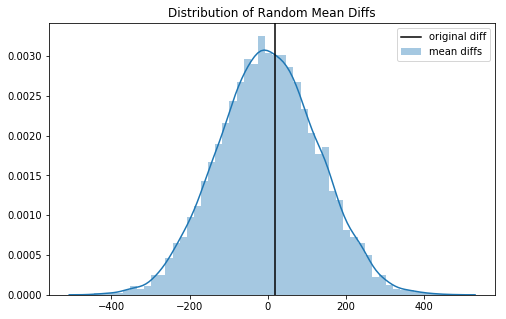

In [ ]:
# Plot the distibution of mean differences
plt.figure(figsize=(8,5))
sns.distplot(diffs, label='mean diffs')
plt.axvline(original_diff, color='black', label='original diff')
plt.title('Distribution of Random Mean Diffs')
plt.legend()
plt.show()

We can see that both p-values are around 0.90, meaning we fail to reject the null hypothesis.  Thus we cannot say with 95% confidence that there is a significant difference between average revenue made in the USA vs the UK without it being due to random chance.  

## ANOVA
Let's take this further to see if there is any significant difference in average revenue between the employees.

In [ ]:
# Average renue generated by employee
employee_sales_df.Revenue.groupby(employee_sales_df.EmployeeId).describe()

,count,mean,std,min,25%,50%,75%,max
EmployeeId,,,,,,,,
1,123.0,1561.850443,1822.417469,33.75,493.6000,1030.76000,2038.3200,15810.000
2,96.0,1734.768281,2402.969402,40.00,520.3875,994.94000,1861.1000,16387.500
3,127.0,1596.951520,2083.477699,45.00,367.7500,1140.00000,1792.4000,10952.845
4,156.0,1492.890038,1592.512978,18.40,470.2500,1047.00000,1852.3800,11188.400
5,42.0,1637.911488,1822.002722,103.20,526.1550,934.93750,1988.6450,9210.900
6,67.0,1103.181037,948.014839,48.00,459.6000,756.00000,1642.8785,4707.540
7,72.0,1730.114375,2279.490011,36.00,423.0000,825.43750,1955.1000,12615.050
8,104.0,1219.829591,1057.894400,36.00,414.4500,848.12625,1771.3575,4825.000
9,43.0,1797.862012,2265.140009,12.50,396.9000,997.00000,1818.9000,11380.000


In [ ]:
formula = 'Revenue ~ C(EmployeeId)'
lm = ols(formula, employee_sales_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df        F    PR(>F)
C(EmployeeId)  3.358256e+07    8.0  1.23576  0.274783
Residual       2.788901e+09  821.0      NaN       NaN


Same as before we fail to reject any differences between the employees based on average revenue.  This is interesting because although there is no statistical difference between the averages, there is a clear difference in the amount of sales and total revenue.  The USA is generating almost three times the sales as the UK and thus generating more total revenue.  This can be shown in the query below.

In [ ]:
# Query total revenue based on employee
total_revenue_df = pd.read_sql_query('''SELECT e.Id, e.LastName, e.FirstName,
                            e.TitleOfCourtesy, e.Title, e.Country, e.HireDate,
                            COUNT(DISTINCT od.OrderId) Orders_filled,
                            SUM(od.Quantity) Units_sold,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            GROUP BY e.Id
                            ''', engine)
total_revenue_df

2019-03-11 16:49:25,317 INFO sqlalchemy.engine.base.Engine SELECT e.Id, e.LastName, e.FirstName, 
                            e.TitleOfCourtesy, e.Title, e.Country, e.HireDate,
                            COUNT(DISTINCT od.OrderId) Orders_filled,
                            SUM(od.Quantity) Units_sold,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Revenue
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            GROUP BY e.Id
                            
2019-03-11 16:49:25,319 INFO sqlalchemy.engine.base.Engine ()


,Id,LastName,FirstName,TitleOfCourtesy,Title,Country,HireDate,Orders_filled,Units_sold,Revenue
0,1,Davolio,Nancy,Ms.,Sales Representative,USA,2024-05-01,123,7812,192107.6045
1,2,Fuller,Andrew,Dr.,"Vice President, Sales",USA,2024-08-14,96,6055,166537.7550
2,3,Leverling,Janet,Ms.,Sales Representative,USA,2024-04-01,127,7852,202812.8430
3,4,Peacock,Margaret,Mrs.,Sales Representative,USA,2025-05-03,156,9798,232890.8460
4,5,Buchanan,Steven,Mr.,Sales Manager,UK,2025-10-17,42,3036,68792.2825
5,6,Suyama,Michael,Mr.,Sales Representative,UK,2025-10-17,67,3527,73913.1295
6,7,King,Robert,Mr.,Sales Representative,UK,2026-01-02,72,4654,124568.2350
7,8,Callahan,Laura,Ms.,Inside Sales Coordinator,USA,2026-03-05,104,5913,126862.2775
8,9,Dodsworth,Anne,Ms.,Sales Representative,UK,2026-11-15,43,2670,77308.0665


In [ ]:
usa_df = total_revenue_df[total_revenue_df['Country']=='USA']
uk_df = total_revenue_df[total_revenue_df['Country']=='UK']
print('Difference in Total Revenue: ${}'.format(round(usa_df.Revenue.sum() - uk_df.Revenue.sum(),2)))

Difference in Total Revenue: $576629.61


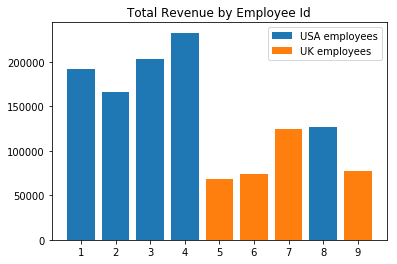

In [ ]:
plt.bar(usa_df.Id, usa_df.Revenue, label='USA employees')
plt.bar(uk_df.Id, uk_df.Revenue, label = 'UK employees')
plt.xticks(total_revenue_df.Id)
plt.title('Total Revenue by Employee Id')
plt.legend()
plt.show()

Let's now see if there are any significant differences between the sales reps for their respective country

In [ ]:
sales_reps_usa = employee_sales_df[(employee_sales_df['Country']=='USA')&(employee_sales_df['Title']=='Sales Representative')]

In [ ]:
# Anova test
formula = 'Revenue ~ C(FirstName)'
lm = ols(formula, sales_reps_usa).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
C(FirstName)  8.005805e+05    2.0  0.119917  0.887025
Residual      1.345233e+09  403.0       NaN       NaN


In [ ]:
sales_reps_uk = employee_sales_df[(employee_sales_df['Country']=='UK')&(employee_sales_df['Title']=='Sales Representative')]

In [ ]:
# ANOVA test
formula = 'Revenue ~ C(FirstName)'
lm = ols(formula, sales_reps_uk).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
C(FirstName)  1.813505e+07    2.0  2.521364  0.083201
Residual      6.437337e+08  179.0       NaN       NaN


Again, we fail to reject both null hypothesis' that there is a significant difference between the sales reps of the USA and between the sales reps in the UK.
<br>
<br>
Let's go one step further to see if there is any significant difference between male and female employees.

In [ ]:
# There is one Dr. and the name is Andrew, will assume male
employee_sales_df.TitleOfCourtesy.unique()

array(['Mr.', 'Mrs.', 'Ms.', 'Dr.'], dtype=object)

In [ ]:
male_employees = employee_sales_df[(employee_sales_df['TitleOfCourtesy']=='Mr.') |
                                   (employee_sales_df['TitleOfCourtesy']=='Dr.')]
female_employees = employee_sales_df[(employee_sales_df['TitleOfCourtesy']=='Mrs.') |
                                     (employee_sales_df['TitleOfCourtesy']=='Ms.')]

In [ ]:
print('Mean Male Revenue:', np.mean(male_employees.Revenue))
print('Mean Female Revenue:', np.mean(female_employees.Revenue))
print('Mean difference:', np.mean(male_employees.Revenue) - np.mean(female_employees.Revenue))

Mean Male Revenue: 1566.106144404332
Mean Female Revenue: 1504.487590415913
Mean difference: 61.61855398841908


In [ ]:
# Two sample t-test (2 tail)
stats.ttest_ind(male_employees.Revenue, female_employees.Revenue)

Ttest_indResult(statistic=0.45344886460688966, pvalue=0.6503443688380031)

And again we fail to reject the null hypothesis, thus there is no significant difference between male and female employees based on the average revenue the bring in.  Hopefully there is equal pay between male and females in their respective roles.


## Results
Overall based on our findings, we cannot confidently say there is any statistically significant difference between average revenues generated between the USA and the UK.  We can however say there is a big discrepency between total orders filled and thus total revenue as well where the USA generates much more revenue than the UK.  This could be due to factors where conditions are different in one country versus the other with regards to policy or trade agreements. Or it could also mean that marketying should be pushing more in European market to get more exposure since the UK branch is generating the same revenues on average, they just need more orders. It could also mean they are less efficient for whatever reason, but possibly more data would need to be collected, since there are only 9 employeeds.


**_Is there any statistically significant difference between shipping companies based on their ship time? What about based on their freight price?_**

In [ ]:
# Get shipping data from Orders table
orders_df = pd.read_sql_query('''SELECT * FROM [Order] o JOIN Shipper s ON s.Id = o.ShipVia
                            ''', engine)
orders_df.head()

2019-03-11 16:49:35,989 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order] o JOIN Shipper s ON s.Id = o.ShipVia
                            
2019-03-11 16:49:35,992 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,CompanyName,Phone
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,3,Federal Shipping,(503) 555-9931
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1,Speedy Express,(503) 555-9831
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,2,United Package,(503) 555-3199
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,1,Speedy Express,(503) 555-9831
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2,United Package,(503) 555-3199


In [ ]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 17 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null object
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
Id                830 non-null int64
CompanyName       830 non-null object
Phone             830 non-null object
dtypes: float64(1), int64(4), object(12)
memory usage: 110.3+ KB


In [ ]:
# Change RequiredDate and OrderDate to date time, and add column ShippingTime
orders_df['RequiredDate'] = pd.to_datetime(orders_df['RequiredDate'])
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'])
orders_df['ShippingTime'] = orders_df['RequiredDate'] - orders_df['OrderDate']
orders_df

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,CompanyName,Phone,ShippingTime
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,3,Federal Shipping,(503) 555-9931,28 days
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1,Speedy Express,(503) 555-9831,42 days
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,2,United Package,(503) 555-3199,28 days
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,1,Speedy Express,(503) 555-9831,28 days
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2,United Package,(503) 555-3199,28 days
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,2,United Package,(503) 555-3199,14 days
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland,2,United Package,(503) 555-3199,28 days
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland,3,Federal Shipping,(503) 555-9931,28 days
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,2,United Package,(503) 555-3199,28 days
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela,3,Federal Shipping,(503) 555-9931,28 days


In [ ]:
# Make new df
shipping_df = orders_df[['CompanyName', 'OrderDate', 'RequiredDate', 'ShippingTime']]
shipping_df.head()

,CompanyName,OrderDate,RequiredDate,ShippingTime
0,Federal Shipping,2012-07-04,2012-08-01,28 days
1,Speedy Express,2012-07-05,2012-08-16,42 days
2,United Package,2012-07-08,2012-08-05,28 days
3,Speedy Express,2012-07-08,2012-08-05,28 days
4,United Package,2012-07-09,2012-08-06,28 days


In [ ]:
shipping_df.isna().sum()

CompanyName     0
OrderDate       0
RequiredDate    0
ShippingTime    0
dtype: int64

In [ ]:
# Change ShippingTime column to just amount of days
shipping_df['ShippingTime'] = shipping_df['ShippingTime'].dt.days

In [ ]:
shipping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
CompanyName     830 non-null object
OrderDate       830 non-null datetime64[ns]
RequiredDate    830 non-null datetime64[ns]
ShippingTime    830 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 26.0+ KB


In [ ]:
# shipping time seems to take either 2, 4, or 6 weeks
shipping_df.ShippingTime.unique()

array([28, 42, 14])

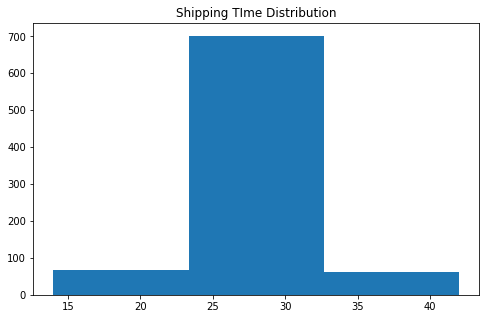

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(shipping_df.ShippingTime, bins=3)
plt.title('Shipping TIme Distribution')
plt.show()

## Hypothesis
Null Hypothesis: The average shipping time for all three shipping companies are equal
<br>

$H_0: \mu_1 = \mu_2 = \mu_3$
<br>

Alternative Hypothesis: The average shipping time for all three shipping companies are not equal
<br>

$H_a: \mu_1 != \mu_2 != \mu_3$
<br>

We want to look for significant differences between the shipping companies' shipping times to see if we can improve shipping logistics.
<br>

Will also use an $\alpha$ = 0.05

In [ ]:
shipping_df.ShippingTime.groupby(shipping_df.CompanyName).describe()

,count,mean,std,min,25%,50%,75%,max
CompanyName,,,,,,,,
Federal Shipping,255.0,27.505882,5.463458,14.0,28.0,28.0,28.0,42.0
Speedy Express,249.0,28.056225,5.692104,14.0,28.0,28.0,28.0,42.0
United Package,326.0,28.042945,5.435892,14.0,28.0,28.0,28.0,42.0


## ANOVA test

In [ ]:
# ANOVA test
formula = 'ShippingTime ~ C(CompanyName)'
lm = ols(formula, shipping_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df         F    PR(>F)
C(CompanyName)     52.076115    2.0  0.853813  0.426163
Residual        25220.352801  827.0       NaN       NaN


After running the ANOVA test, we fail to reject the Null Hypothesis and we cannot say with 95% confidence that there is a statistically significant difference between the three shipping companies' average shipping times.
<br>

Now let's test if there is any significant difference between the three shipping companies' average freight costs.  This would help the company by selecting the best shipping companies.  Note that freight is the cost after the cost of the goods being shipped, basically a total shipping cost.

In [ ]:
freight_df = orders_df[['CompanyName', 'Freight']]

In [ ]:
freight_df.Freight.groupby(freight_df.CompanyName).describe()[['count', 'mean']]

,count,mean
CompanyName,,
Federal Shipping,255.0,80.441216
Speedy Express,249.0,65.001325
United Package,326.0,86.640644


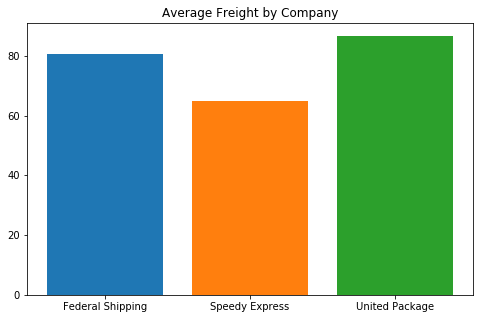

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Average Freight by Company')

comapanies = freight_df.CompanyName.unique()
for company in comapanies:
    plt.bar(company, freight_df[freight_df['CompanyName']==company]['Freight'].mean())

plt.show()

Notice how Speedy Express has the lowest average freight cost out of all the shipping companies.  

In [ ]:
speedy_express = freight_df[freight_df['CompanyName']=='Speedy Express']
print('Pop Mean:', np.mean(freight_df.Freight))
print('SE Mean:', np.mean(speedy_express.Freight))
print('Mean Diff:', np.mean(speedy_express.Freight) - np.mean(freight_df.Freight))

Pop Mean: 78.2442048192771
SE Mean: 65.00132530120482
Mean Diff: -13.242879518072286


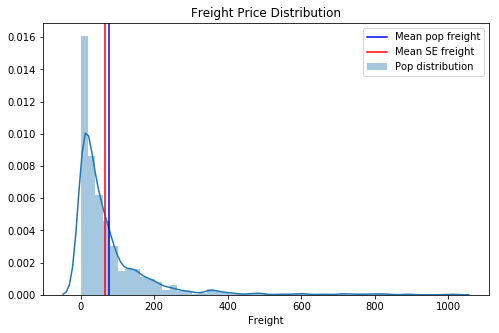

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(freight_df.Freight, label='Pop distribution')
plt.axvline(np.mean(freight_df.Freight), color='blue', label='Mean pop freight')
plt.axvline(np.mean(freight_df[freight_df['CompanyName']=='Speedy Express']['Freight']), color='red', label='Mean SE freight')
plt.title('Freight Price Distribution')
plt.legend()
plt.show()

Notice how the average freight for Speedy Express is less than the average freight for all the shipping companies.
<br>
## Hypothesis
Let's run a one sample t-test(one-tail) for the following hypothesis test:
<br>

Null Hypothesis: $\mu_p$ <= $\mu_s$
<br>

Alternative Hypothesis: $\mu_p$ > $\mu_s$
<br>

Basically we want to see if the average freight for Speedy Express is significantly less than the average freight for the population.

## One Sample T-Test (one tail, left)

In [ ]:
t_stat, p_val = stats.ttest_1samp(freight_df[freight_df['CompanyName']=='Speedy Express']['Freight'], np.mean(freight_df.Freight))
print('P-value:', p_val/2)

P-value: 0.0029995288773551703


## Accept or Reject
Here with a p-value less than 0.05, we reject our null hypothesis, therefore we can say with 95% confidence that the average freight for Speedy express is signifcantly cheaper than the population.
<br>

Let's now dig further to see if there is any signficance between the average freights for each of the shipping companies.

## Effect Size

In [ ]:
d = Cohen_d(speedy_express.Freight, freight_df.Freight)
print('d = {}'.format(d))

d = -0.12190001384301669


Notice though, the effect size is very small, more data may be needed.

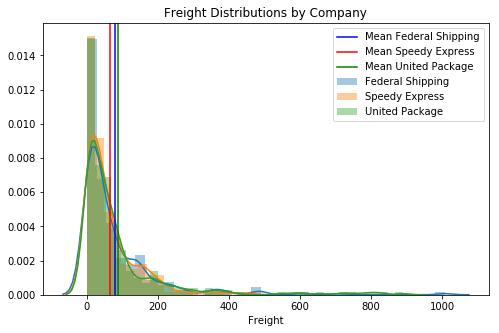

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(freight_df[freight_df['CompanyName']=='Federal Shipping']['Freight'], label='Federal Shipping')
sns.distplot(freight_df[freight_df['CompanyName']=='Speedy Express']['Freight'], label='Speedy Express')
sns.distplot(freight_df[freight_df['CompanyName']=='United Package']['Freight'], label='United Package')
plt.axvline(np.mean(freight_df[freight_df['CompanyName']=='Federal Shipping']['Freight']), color='blue', label='Mean Federal Shipping')
plt.axvline(np.mean(freight_df[freight_df['CompanyName']=='Speedy Express']['Freight']), color='red', label='Mean Speedy Express')
plt.axvline(np.mean(freight_df[freight_df['CompanyName']=='United Package']['Freight']), color='green', label='Mean United Package')
plt.title('Freight Distributions by Company')
plt.legend()
plt.show()

In [ ]:
# ANOVA test
formula = 'Freight ~ C(CompanyName)'
lm = ols(formula, freight_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df        F    PR(>F)
C(CompanyName)  6.788200e+04    2.0  2.49781  0.082885
Residual        1.123753e+07  827.0      NaN       NaN


Although the average freight costs seem different, we fail to reject the Null Hypothesis, thuse we cannot say with 95% confidence that there is a significant difference between the companies' freight costs without it being due to random chance.

## Results
Overall, from our findings with regards to the three shipping companies, we did not find any significant difference between their average shipping times or freight costs specifically against each other.  However, testing the average freight of the company with the lowest freight on average, Speedy Express, we can say with 95% confidence that their freight is significantly lower than the general average freight overall. This information is useful for if the company wants to go with one freight company they should go with Speedy Express.



**_Is there any statistical significance on the average revenue generated in the USA compared to the average revenue generated in the rest of the countries?_**

In [ ]:
region_df = pd.read_sql_query('''SELECT od.OrderId, o.ShipRegion, o.ShipCountry, SUM(od.Quantity) Quantity,
                            SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) Revenue
                            FROM [Order] o
                            JOIN OrderDetail od ON od.OrderId = o.Id
                            GROUP BY od.OrderId
                            ''', engine)
region_df.head()

2019-03-11 16:49:54,964 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, o.ShipRegion, o.ShipCountry, SUM(od.Quantity) Quantity,
                            SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) Revenue
                            FROM [Order] o 
                            JOIN OrderDetail od ON od.OrderId = o.Id
                            GROUP BY od.OrderId
                            
2019-03-11 16:49:54,967 INFO sqlalchemy.engine.base.Engine ()


,OrderId,ShipRegion,ShipCountry,Quantity,Revenue
0,10248,Western Europe,France,27,440.00
1,10249,Western Europe,Germany,49,1863.40
2,10250,South America,Brazil,60,1552.60
3,10251,Western Europe,France,41,654.06
4,10252,Western Europe,Belgium,105,3597.90


In [ ]:
region_df.shape

(830, 5)

In [ ]:
# Ranking region by total revenue
region_df.Revenue.groupby(region_df.ShipCountry).sum().sort_values(ascending=False)

ShipCountry
USA            245584.6105
Germany        230284.6335
Austria        128003.8385
Brazil         106925.7765
France          81358.3225
UK              58971.3100
Venezuela       56810.6290
Sweden          54495.1400
Canada          50196.2900
Ireland         49979.9050
Belgium         33824.8550
Denmark         32661.0225
Switzerland     31692.6590
Mexico          23582.0775
Finland         18810.0525
Spain           17983.2000
Italy           15770.1550
Portugal        11472.3625
Argentina        8119.1000
Norway           5735.1500
Poland           3531.9500
Name: Revenue, dtype: float64

In [ ]:
# Ranking region by average revenue
# Note how USA generates more total revenue than the rest of the countries
# But on average is the third highest
region_df.Revenue.groupby(region_df.ShipCountry).describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ShipCountry,,,,,,,,
Austria,40.0,3200.095963,2242.820195,344.000,1512.6000,2499.7500,4747.1250,8623.4500
Ireland,19.0,2630.521316,2405.328466,562.600,1354.6750,2023.3800,2582.0000,10835.2400
USA,122.0,2012.988611,2296.524603,36.000,507.7500,1336.5350,2477.5750,12615.0500
Germany,122.0,1887.578963,2376.494559,86.400,598.0000,1199.3750,2026.5600,16387.5000
Denmark,18.0,1814.501250,2509.507709,48.750,706.0000,887.8500,1893.4000,11188.4000
Belgium,19.0,1780.255526,1259.271010,28.000,848.2500,1434.0000,2482.1500,4581.0000
Switzerland,18.0,1760.703278,1047.708150,458.755,1103.2450,1708.8000,2258.1750,4666.9400
Canada,30.0,1673.209667,1822.097425,57.500,659.3000,1051.6625,1877.3875,9194.5600
Sweden,37.0,1472.841622,1226.215410,74.400,601.8300,1096.2000,2222.2000,4895.4375


## Get USA Sample

In [ ]:
# Make usa sample
usa = region_df[region_df['ShipCountry']=='USA']
print('population mean:', np.mean(region_df.Revenue))
print('usa mean:', np.mean(usa.Revenue))
print('mean difference:', np.mean(usa.Revenue) - np.mean(region_df.Revenue))

population mean: 1525.051854819277
usa mean: 2012.9886106557378
mean difference: 487.93675583646086


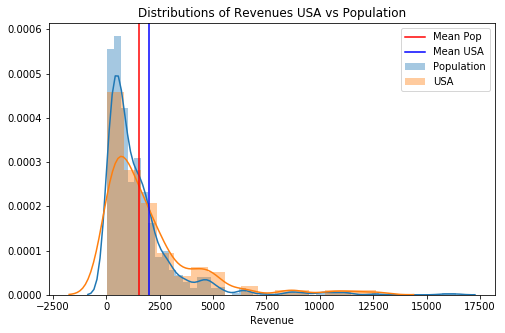

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(region_df.Revenue, label='Population')
sns.distplot(usa.Revenue, label='USA')
plt.axvline(np.mean(region_df.Revenue), color='red', label='Mean Pop')
plt.axvline(np.mean(usa.Revenue), color='blue', label='Mean USA')
plt.title('Distributions of Revenues USA vs Population')
plt.legend()
plt.show()

## Hypothesis
Null Hypothesis: The average revenue for all the countries is at least equal to the average revenue for the USA.
<br>

$H_0: \mu_c >= \mu_e$
<br>

Alternative Hypothesis: The average revenue for the USA is greater than the average revenue for all the countries.
<br>

$H_a: \mu_c < \mu_e$
<br>

We want to see if there is a significant difference between the average revenue for the USA.
<br>

Will also use an $\alpha$ = 0.05

## One Sample T-Test (one tail)

In [ ]:
t_stat, p_val = stats.ttest_1samp(usa.Revenue, np.mean(region_df.Revenue))
print('P-Value:', p_val/2)

P-Value: 0.01028069250065511


## Accept or Reject
Based on the p-value being less than our alpha, we can reject the Null Hypothesis and say with 95% confidence that the average revenue from the USA is greater than the average revenue from all of the countries without it being due to random chance.

## Effect Size

In [ ]:
d = Cohen_d(usa.Revenue, region_df.Revenue)
print('d = {}'.format(d))

d = 0.2555994419667684


An effect of 0.26 is considered a small effect.  Although it is small, it still means that there is a an effect happening but it is not so obvious to see without investigating like we have with our hypothesis testing.
<br>

Let's see now if we can get some insight on what are the top products sold in the USA.

In [ ]:
products_df = pd.read_sql_query('''SELECT od.OrderId,
                            c.CategoryName,
                            o.ShipRegion,
                            o.ShipCountry,
                            od.Quantity,
                            (od.Quantity * od.UnitPrice * (1 - od.Discount)) Revenue
                            From [Order] o
                            JOIN OrderDetail od ON od.OrderId = o.Id
                            JOIN Product p ON od.ProductId = p.Id
                            JOIN Category c ON c.Id = p.CategoryId
                            ''', engine)
products_df.head()

2019-03-11 16:50:03,956 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            c.CategoryName,
                            o.ShipRegion,
                            o.ShipCountry,
                            od.Quantity,
                            (od.Quantity * od.UnitPrice * (1 - od.Discount)) Revenue
                            From [Order] o
                            JOIN OrderDetail od ON od.OrderId = o.Id
                            JOIN Product p ON od.ProductId = p.Id
                            JOIN Category c ON c.Id = p.CategoryId
                            
2019-03-11 16:50:03,959 INFO sqlalchemy.engine.base.Engine ()


,OrderId,CategoryName,ShipRegion,ShipCountry,Quantity,Revenue
0,10248,Dairy Products,Western Europe,France,12,168.0
1,10248,Grains/Cereals,Western Europe,France,10,98.0
2,10248,Dairy Products,Western Europe,France,5,174.0
3,10249,Produce,Western Europe,Germany,9,167.4
4,10249,Produce,Western Europe,Germany,40,1696.0


In [ ]:
products_df.shape

(2155, 6)

In [ ]:
products_df.isna().sum()

OrderId         0
CategoryName    0
ShipRegion      0
ShipCountry     0
Quantity        0
Revenue         0
dtype: int64

In [ ]:
# Average revenue by product category
products_df.Revenue.groupby(products_df.CategoryName).describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
CategoryName,,,,,,,,
Meat/Poultry,173.0,942.325777,1296.746872,17.8800,196.800000,472.000,1170.00,9903.2
Produce,136.0,735.180735,768.655001,22.5525,217.040625,511.300,1060.00,6042.0
Beverages,404.0,663.040050,1685.811331,13.5000,108.000000,251.550,504.00,15810.0
Dairy Products,366.0,640.730287,691.701096,8.5000,190.500000,436.350,858.75,6050.0
Confections,334.0,501.069536,618.259773,7.3000,139.875000,321.000,589.25,5268.0
Condiments,216.0,490.958727,462.281963,17.0000,195.000000,340.625,604.00,2565.0
Grains/Cereals,196.0,488.492793,531.827940,14.0000,126.000000,374.300,665.00,4322.5
Seafood,330.0,397.762841,426.114617,4.8000,115.800000,287.100,501.65,3125.0


In [ ]:
# Average revenue by product category in the USA
usa_products = products_df[products_df['ShipCountry']=='USA']
usa_products.Revenue.groupby(usa_products.CategoryName).describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
CategoryName,,,,,,,,
Meat/Poultry,37.0,1125.271216,1384.535293,29.8000,223.50,592.8000,1638.000,5570.55
Beverages,61.0,992.147131,2004.364151,31.0000,134.40,285.0000,581.400,10540.00
Dairy Products,55.0,689.128091,854.036488,16.0000,81.25,412.5000,933.800,4125.00
Confections,62.0,585.724726,632.692204,30.0000,136.00,383.2000,747.375,2758.00
Grains/Cereals,33.0,584.562576,489.182896,14.0000,199.50,425.6000,798.000,2128.00
Produce,18.0,545.351528,480.043048,22.5525,213.75,408.0000,782.475,1800.00
Condiments,33.0,502.955379,597.041739,17.0000,85.40,268.3875,616.000,2386.80
Seafood,53.0,443.532123,423.737336,24.0000,157.32,304.0000,562.500,2170.00


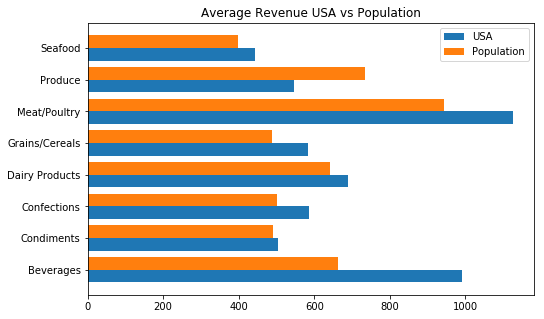

In [ ]:
pop_avg = pd.DataFrame(products_df.Revenue.groupby(products_df.CategoryName).mean())
usa_avg = pd.DataFrame(usa_products.Revenue.groupby(usa_products.CategoryName).mean())

plt.figure(figsize=(8,5))
plt.barh(usa_avg.index, usa_avg.Revenue, label='USA', height=-0.4, align='edge')
plt.barh(pop_avg.index, pop_avg.Revenue, label='Population', height=0.4, align='edge')
plt.title('Average Revenue USA vs Population')
plt.legend()
plt.show()

It seems there is a big discrpency between the amount of Produce sold in the US, let's test to see if it is significant.

In [ ]:
# 1 sample two tail t-test seeing if there is a significant difference between
# Produce sold in the USA vs in the population.
# Null Hypothesis: USA mean produce is greater than or equal to the population mean produce
# Alternative Hypothesis: USA mean produce is less than the population mean produce
t_stat, p_val = stats.ttest_1samp(usa_products[usa_products['CategoryName']=='Produce']['Revenue'],
                  np.mean(products_df[products_df['CategoryName']=='Produce']['Revenue']))
print('P-value:', p_val/2)

P-value: 0.055845002081287516


Here we fail to reject the null hypothesis that there is any significant difference between the average amount of produce sold in the USA vs the average amount sold in all the countries.  This is despite the fact that the average revenue from produce in the USA is lower, due to there being a small sample size we cannot say with 95% confidence that there is any significance.

## Results
Based on our hypothesis testing, we can be 95% sure that there is a significant difference between the average revenue generated in the USA vs the average revenue generated overall.  This information is useful and can also be tested with other countries in order to target the top revenue generating areas.  
<br>
Further testing can be done to target in on specific countries in order to look for significance in the amount of revenue generated by product category for each country. However more data might be needed since when we get more specific our sample sizes decrease.  We saw that the US generates a lot less revenue from produce on average, but it still wasn't statistically significant.  This trend can be examined further as we get more data.



**_Is there any statistically significant difference between the average reveue brought in from the first quarter of 2014 versus the first quarter of 2013?_**

In [ ]:
revenue_df = pd.read_sql_query('''SELECT o.Id,
                                o.OrderDate,
                                SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) Revenue
                                FROM [Order] o
                                JOIN OrderDetail od ON od.OrderId=o.Id
                                GROUP BY o.Id''', engine)
revenue_df.head()

2019-03-11 16:50:11,076 INFO sqlalchemy.engine.base.Engine SELECT o.Id,
                                o.OrderDate,
                                SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) Revenue
                                FROM [Order] o
                                JOIN OrderDetail od ON od.OrderId=o.Id
                                GROUP BY o.Id
2019-03-11 16:50:11,079 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderDate,Revenue
0,10248,2012-07-04,440.00
1,10249,2012-07-05,1863.40
2,10250,2012-07-08,1552.60
3,10251,2012-07-08,654.06
4,10252,2012-07-09,3597.90


In [ ]:
revenue_df.shape

(830, 3)

In [ ]:
revenue_df.OrderDate = pd.to_datetime(revenue_df.OrderDate)

In [ ]:
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 3 columns):
Id           830 non-null int64
OrderDate    830 non-null datetime64[ns]
Revenue      830 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 19.5 KB


In [ ]:
revenue_df['OrderDate'].dt.year.value_counts()

2013    408
2014    270
2012    152
Name: OrderDate, dtype: int64

In [ ]:
revenue_df['year'] = revenue_df['OrderDate'].dt.year
revenue_df['month'] = revenue_df['OrderDate'].dt.month

In [ ]:
revenue_df.head()

,Id,OrderDate,Revenue,year,month
0,10248,2012-07-04,440.00,2012,7
1,10249,2012-07-05,1863.40,2012,7
2,10250,2012-07-08,1552.60,2012,7
3,10251,2012-07-08,654.06,2012,7
4,10252,2012-07-09,3597.90,2012,7


## Create Sample Groups

In [ ]:
q1_2014 = revenue_df[(revenue_df['year']==2014) & ((revenue_df['month']==1)|(revenue_df['month']==2)|(revenue_df['month']==3))]
q1_2013 = revenue_df[(revenue_df['year']==2013) & ((revenue_df['month']==1)|(revenue_df['month']==2)|(revenue_df['month']==3))]

In [ ]:
print('Q1 2014 Mean Revenue:', np.mean(q1_2014.Revenue))
print('Q1 2013 Mean Revenue:', np.mean(q1_2013.Revenue))
print('Q1 Mean Difference:', np.mean(q1_2014.Revenue) - np.mean(q1_2013.Revenue))

Q1 2014 Mean Revenue: 1640.0634780219784
Q1 2013 Mean Revenue: 1503.1404891304353
Q1 Mean Difference: 136.92298889154313


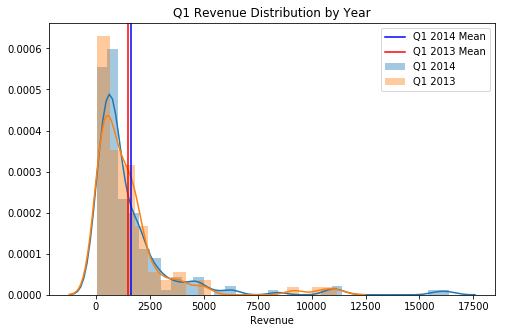

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(q1_2014.Revenue, label='Q1 2014')
sns.distplot(q1_2013.Revenue, label='Q1 2013')
plt.axvline(np.mean(q1_2014.Revenue), color='blue', label='Q1 2014 Mean')
plt.axvline(np.mean(q1_2013.Revenue), color='red', label='Q1 2013 Mean')
plt.title('Q1 Revenue Distribution by Year')
plt.legend()
plt.show()

## Hypothesis
Null Hypothesis: The average revenue for Q1 2013 is at least equal to the average revenue for Q1 2014.
<br>

$H_0: \mu_a >= \mu_b$
<br>

Alternative Hypothesis: The average revenue for Q1 2014 is greater than the average revenue for Q1 2013.
<br>

$H_a: \mu_a < \mu_b$
<br>

We want to see if there is a significant difference between the average revenue between the first quarters for 2014 and 2013.
<br>

Will also use an $\alpha$ = 0.05

## Two Sample T-Test

In [ ]:
t_stat, p_val = stats.ttest_ind(q1_2014.Revenue, q1_2013.Revenue, equal_var=False)
print('P-value:', p_val/2)

P-value: 0.30482066706087185


## Accept or Reject
Here we fail to reject the Null Hypothesis, thus we cannot say with 95% confidence that there is any statistical significance between Q1 2014 and Q1 2013 average revenue without it being due to random chance.

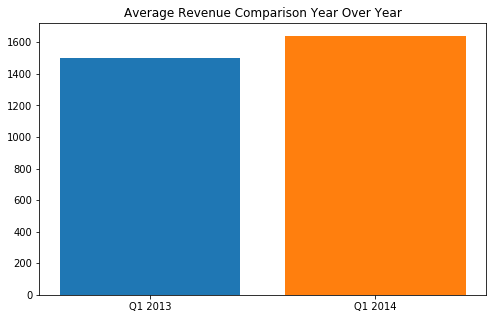

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(x='Q1 2013', height = np.mean(q1_2013.Revenue))
plt.bar(x='Q1 2014', height = np.mean(q1_2014.Revenue))
plt.title('Average Revenue Comparison Year Over Year')
plt.show()

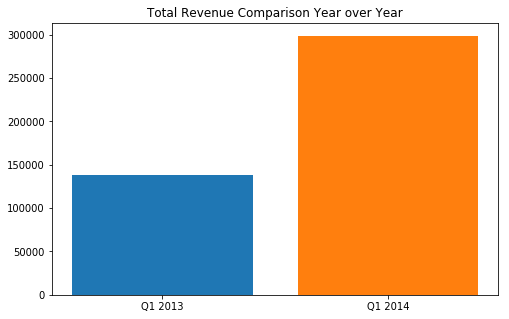

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(x='Q1 2013', height = (q1_2013.Revenue.sum()))
plt.bar(x='Q1 2014', height = (q1_2014.Revenue.sum()))
plt.title('Total Revenue Comparison Year over Year')
plt.show()

## Results
Although we failed to reject our null hypothesis and we cannot say with 95% confidence that the average revenue generated in Q1 2014 is greater than that of Q1 2013, we can still notice that total revenue has increased.  This shows that with out average revenue staying the same, we have been increasing the amount of orders and therefor generating more revenue overall.